# Importing libraries.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import torch
from kan import KAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

In [24]:
use_cuda_if_available = False
device_name = "cuda" if torch.cuda.is_available() and use_cuda_if_available else "cpu"
DEVICE = torch.device("cuda" if torch.cuda.is_available() and use_cuda_if_available else "cpu")
DEVICE

device(type='cpu')

# Load and preprocess images.

In [25]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return ValueError(f"Unable to load file {image_path}")
    
    img = cv2.resize(img, (64, 64))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = img / 255

    img_flattened = img.flatten()

    return img_flattened

# Load train and test dataset.

In [26]:
def load_train_dataset(csv_path, images_dir):
    df = pd.read_csv(csv_path)

    x = []
    y = []

    print("Loading train images...")
    for idx, row in df.iterrows():
        img_filename = f"{row['id_code']}.jpg"
        img_path = os.path.join(images_dir, img_filename)

        try:
            img_vector = load_and_preprocess_image(img_path)
            x.append(img_vector)
            y.append(row['diagnosis'])
        except Exception as e:
            print(f"Error preprocessing image {img_path}: {e}")

    x = np.array(x, dtype=np.float32)
    y = np.array(y)

    print(f"Loaded {len(x)} size of train data")
    
    return x, y


# Prepare data.

### Get train data and split it for train and validation.

In [27]:
trainCsvPath = "data/trainLabels.csv"
trainImagesPath = "data/train"
testCsvPath = "data/testImages.csv"
testImagesPath = "data/test"

x, y = load_train_dataset(trainCsvPath, trainImagesPath)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)

print("Train and val data shape:")
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Validation: {x_val.shape}, {y_val.shape}")

Loading train images...
Loaded 3662 size of train data
Train and val data shape:
Train: (3112, 12288), (3112,)
Validation: (550, 12288), (550,)


### Compute class weights to solve class imbalance.

In [28]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Computed class weights:")
for cls, weight in class_weight_dict.items():
    print(f"  Class {cls}: weight = {weight:.2f}")

Computed class weights:
  Class 0: weight = 0.41
  Class 1: weight = 1.98
  Class 2: weight = 0.73
  Class 3: weight = 3.80
  Class 4: weight = 2.48


### Transform into tensors.

In [29]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

if use_cuda_if_available:
    x_train_tensor = x_train_tensor.to(DEVICE)
    y_train_tensor = y_train_tensor.to(DEVICE)
    x_val_tensor = x_val_tensor.to(DEVICE)
    y_val_tensor = y_val_tensor.to(DEVICE)

# Create and train our model.

In [30]:
pca = PCA(100)
x_train = pca.fit_transform(x_train)

input_dim = x_train.shape[1]
output_dim = len(np.unique(y_train))

model = KAN(width=[input_dim, 32, output_dim], grid=3, k=2, seed=42, device=device_name)

print(model)

checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)


# Training model.

In [ ]:
def train_model_with_val(model, x_train, y_train, x_val, y_val, epochs=9999, lr=1e-3, print_epoch_every=5, early_stopping=True, class_weight_dict=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if class_weight_dict:
        weight_tensor = torch.tensor(list(class_weight_dict.values()), dtype=torch.float32).to(DEVICE)
        criterion = torch.nn.CrossEntropyLoss(weight=weight_tensor)

    train_losses = []
    val_losses = []
    val_acc = []

    last_val_loss = 999999.0
    for epoch in range(epochs):
        model.train()
        predictions = model(x_train)

        if class_weight_dict:
            loss = criterion(predictions, y_train)
        else:
            loss = torch.nn.functional.cross_entropy(predictions, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val)
            val_loss =  torch.nn.functional.cross_entropy(val_predictions, y_val)
            val_pred_classes = torch.argmax(val_predictions, dim=1)
            val_accuracy = accuracy_score(y_val.numpy(), val_pred_classes.numpy())

        val_losses.append(val_loss.item())
        val_acc.append(val_accuracy)

        if epoch % print_epoch_every == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch}; train loss={loss.item():.4f}; val loss: {val_loss.item():.4f}; val acc: {val_accuracy:.4f}")
        
        if (val_loss.item() >= last_val_loss) and early_stopping:
            break

        last_val_loss = val_loss.item()

    return train_losses, val_losses, val_acc

In [34]:
print("Training...")
train_losses, val_losses, val_acc = train_model_with_val(model, x_train_tensor, y_train_tensor, x_val_tensor, y_val_tensor, early_stopping=False, class_weight_dict=class_weight_dict)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss plot')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(val_acc)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Training...
Epoch: 0; train loss=1.5990; val loss: 1.5527; val acc: 0.6691
Epoch: 5; train loss=1.5815; val loss: 1.5599; val acc: 0.5836
Epoch: 10; train loss=1.5625; val loss: 1.5368; val acc: 0.5636
Epoch: 15; train loss=1.5396; val loss: 1.4948; val acc: 0.6091
Epoch: 20; train loss=1.5129; val loss: 1.4424; val acc: 0.6345
Epoch: 25; train loss=1.4832; val loss: 1.3844; val acc: 0.6364
Epoch: 30; train loss=1.4519; val loss: 1.3246; val acc: 0.6291
Epoch: 35; train loss=1.4209; val loss: 1.2680; val acc: 0.6055
Epoch: 40; train loss=1.3923; val loss: 1.2189; val acc: 0.5855
Epoch: 45; train loss=1.3678; val loss: 1.1795; val acc: 0.5691
Epoch: 50; train loss=1.3488; val loss: 1.1506; val acc: 0.5600
Epoch: 55; train loss=1.3352; val loss: 1.1325; val acc: 0.5582
Epoch: 60; train loss=1.3259; val loss: 1.1230; val acc: 0.5545
Epoch: 65; train loss=1.3194; val loss: 1.1177; val acc: 0.5491
Epoch: 70; train loss=1.3143; val loss: 1.1134; val acc: 0.5400
Epoch: 75; train loss=1.3096; 

KeyboardInterrupt: 

# Validate model.

Val accuracy: 61.82%
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       271
           1       0.24      0.27      0.25        56
           2       0.56      0.45      0.50       150
           3       0.20      0.31      0.25        29
           4       0.15      0.20      0.17        44

    accuracy                           0.62       550
   macro avg       0.41      0.42      0.41       550
weighted avg       0.65      0.62      0.63       550



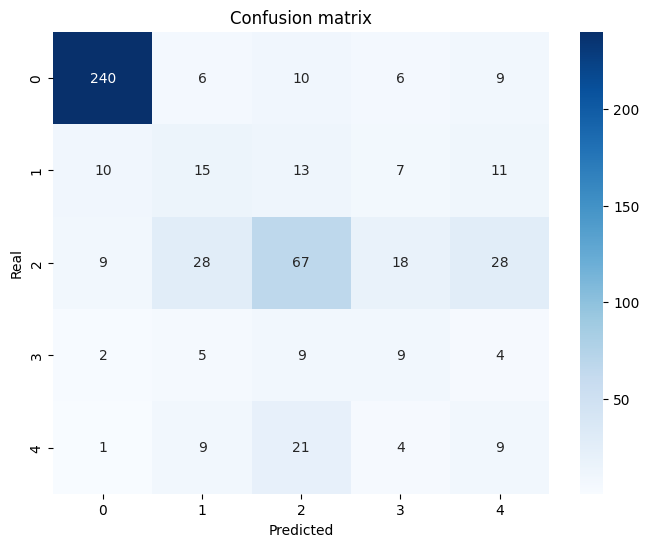

In [35]:
with torch.no_grad():
    model.eval()
    val_predictions = model(x_val_tensor)
    val_pred_classes = torch.argmax(val_predictions, dim=1)


accuracy = accuracy_score(y_val_tensor.numpy(), val_pred_classes.numpy())
print(f"Val accuracy: {accuracy*100:.2f}%")

print(classification_report(y_val, val_pred_classes.numpy()))

confMatrix = confusion_matrix(y_val, val_pred_classes.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix")
plt.ylabel("Real")
plt.xlabel("Predicted")
plt.show()

In [16]:
def train_model(model, x_train, y_train, epochs=200, lr=1e-3, print_epoch_every=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        model.train()
        predictions = model(x_train)

        loss = torch.nn.functional.cross_entropy(predictions, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % print_epoch_every == 0  or epoch == epochs - 1:
            print(f"Epoch: {epoch}; train loss={loss.item():.4f};")

    return train_losses

In [17]:
x_all_train, y_all_train = load_train_dataset(trainCsvPath, trainImagesPath)
x_all_train_tensor = torch.tensor(x_all_train, dtype=torch.float32)
y_all_train_tensor = torch.tensor(y_all_train, dtype=torch.long)


train_losses_all = train_model(model, x_all_train_tensor, y_all_train_tensor)

Loading train images...
Loaded 3662 size of train data
Epoch: 0; train loss=0.7409;
Epoch: 10; train loss=0.7378;
Epoch: 20; train loss=0.7352;
Epoch: 30; train loss=0.7325;
Epoch: 40; train loss=0.7298;
Epoch: 50; train loss=0.7270;
Epoch: 60; train loss=0.7241;
Epoch: 70; train loss=0.7212;
Epoch: 80; train loss=0.7181;
Epoch: 90; train loss=0.7149;
Epoch: 100; train loss=0.7116;
Epoch: 110; train loss=0.7082;
Epoch: 120; train loss=0.7047;
Epoch: 130; train loss=0.7011;
Epoch: 140; train loss=0.6974;
Epoch: 150; train loss=0.6936;
Epoch: 160; train loss=0.6897;
Epoch: 170; train loss=0.6857;
Epoch: 180; train loss=0.6819;
Epoch: 190; train loss=0.6783;
Epoch: 199; train loss=0.6749;


# Load and predict test data

In [18]:
def predict_test_dataset(model, csv_path, images_dir):
    df = pd.read_csv(csv_path)

    test_predictions_list = []
    test_ids = []

    print("Loading test images...")
    for idx, row in df.iterrows():
        img_filename = f"{row['id_code']}.jpg"
        img_path = os.path.join(images_dir, img_filename)

        try:
            img_vector = load_and_preprocess_image(img_path)

            img_tensor = torch.tensor(img_vector, dtype=torch.float32).unsqueeze(0)

            with torch.no_grad():
                prediction = model(img_tensor)
                pred_class = torch.argmax(prediction, dim=1).item()
            
            test_predictions_list.append(pred_class)
            test_ids.append(row['id_code'])
        except Exception as e:
            print(f"Error preprocessing image {img_path}: {e}")

            test_predictions_list.append(0)
            test_ids.append(row['id_code'])

    print(f"Loaded and predicted {len(x)} sized test data")

    return test_ids, test_predictions_list
            

In [19]:
test_ids, test_predictions = predict_test_dataset(
    model, 
    testCsvPath, 
    testImagesPath
)

Loading test images...


c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1857.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1857.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less tha

Loaded and predicted 3662 sized test data


# Create final file.

In [ ]:
def create_file(test_ids, predictions, output_path="res.csv"):
    df = pd.DataFrame({'id_code': test_ids, 'diagnosis': predictions})
    
    df.to_csv(output_path, index=False)
    
    unique, counts = np.unique(predictions, return_counts=True)
    for cls, cnt in zip(unique, counts):
        print(f"  Class {cls}: {cnt} images ({cnt/len(predictions)*100:.1f}%)")
    
    return df

In [21]:
df = create_file(test_ids, test_predictions)

print("\nFirst 10 rows:")
print(df.head(10))

  Class 0: 227 imgaes (11.8%)
  Class 1: 67 imgaes (3.5%)
  Class 2: 1502 imgaes (77.9%)
  Class 3: 79 imgaes (4.1%)
  Class 4: 53 imgaes (2.7%)

First 10 rows:
        id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          2
2  006efc72b638          2
3  00836aaacf06          2
4  009245722fa4          2
5  009c019a7309          2
6  010d915e229a          1
7  0111b949947e          0
8  01499815e469          2
9  0167076e7089          3


# Spline plot.

ValueError: alpha (nan) is outside 0-1 range

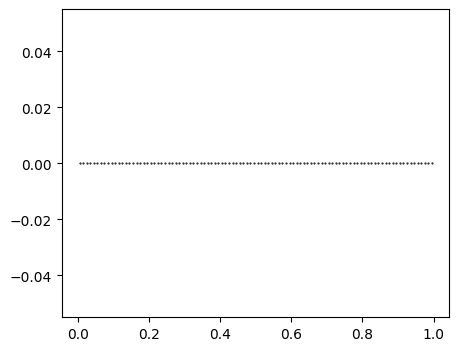

In [22]:
model.plot()